In [1]:
import pandas as pd

df = pd.read_csv('300-noticias-v2-filtradas.csv')
df

,Unnamed: 0,Fonte,ID,text,Tematica,Rótulo,Tipo_Dado,Texto_Original
0,0,G1,0,"A publicação é intitulada ""REVIRAVOLTA no FGTS...",Política,falso,Imagem,REVIRAVOLTA no FGTS 2024: Lula autorizou SAQUE...
1,2,G1,2,"Com voto de Dino, Primeira Turma do STF mantém...",Política,real,Texto,"Com voto de Dino, Primeira Turma do STF mantém..."
2,3,G1,3,Bolsonaro presta depoimento na PF e nega ter i...,Política,real,Texto,Bolsonaro presta depoimento na PF e nega ter i...
3,4,Aos Fatos,4,Governo Lula publica aumento ao Auxílio-Reclus...,Política,falso,Imagem,"Governo Lula ""publica aumento ao Auxílio-Reclu..."
4,5,G1,5,É #FAKE que Ministério da Justiça vai indeniza...,Política,falso,Vídeo,Noticia G1: Jovem tenta pular o muro de residê...
...,...,...,...,...,...,...,...,...
295,472,G1,472,Governo pratica congelamento não declarado de ...,Política,real,Texto,Governo pratica congelamento não declarado de ...
296,473,G1,473,"Sem citar Rússia, governo brasileiro condena b...",Política,real,Texto,"Sem citar Rússia, governo brasileiro condena b..."
297,474,G1,474,"Ao STF, PF diz que venda ilegal de joias foi p...",Política,real,Texto,"Ao STF, PF diz que venda ilegal de joias foi p..."
298,475,G1,475,Cerca de R$ 10 bilhões do pacote de corte de g...,Política,real,Texto,Cerca de R$ 10 bilhões do pacote de corte de g...


In [10]:
import ollama

def isFakeNews(model, text):
    response = ollama.chat(model=model, messages=[{
        'role': 'user',
        'content': 'You are a fack-checker. Answer whether the following news is fake or real. Your answer should be only the word *FAKE* or *REAL*.\n Follow the news: ' + text + '\n Remember, your answer should be only the word *FAKE* or *REAL*',
    },])
    return response['message']['content']

In [8]:
text = df.iloc[34]['Texto_Original']
model = 'llama3'

isFakeNews(model, text)

'REAL'

In [ ]:
for model in ['qwen:32b']: #['llama3:8b', 'phi3:14b', 'gemma2:27b', 'qwen2:7b']:
    df = pd.read_csv('300-noticias-v2-filtradas.csv')
    for index, row in df.iterrows():
        while True:
            rsp = isFakeNews(model, ' '.join(row['Texto_Original'].split()[:1000]))
            rsp = rsp.replace('\n', '').replace('(', '').replace(')', '').replace('!', '').replace('*', '').replace('-', '_').replace('.', '')
            rsp = rsp.strip().lower()
            if rsp == 'fake' or rsp == 'real':
                df.at[index,'llm_class'] = rsp
                break
            else:
                print(index,rsp)
    df.to_csv('results/' + model + '.csv')

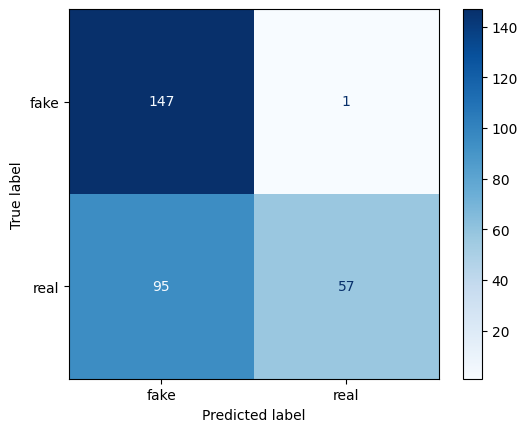

              precision    recall  f1-score   support

        fake       0.61      0.99      0.75       148
        real       0.98      0.38      0.54       152

    accuracy                           0.68       300
   macro avg       0.80      0.68      0.65       300
weighted avg       0.80      0.68      0.65       300



In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

model = 'gpt4'

df = pd.read_csv('results/' + model + '.csv')

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['fake', 'real'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

y_true = ['fake' if l=='falso' else 'real' for l in df.Rótulo.to_list()]
y_pred = [l for l in df.llm_class.to_list()]

plot_confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred))

In [71]:
import openai

def llm_gpt(text):
  response = openai.ChatCompletion.create(
      model="gpt-4",
      messages = [{
        'role': 'user',
        'content': 'You are a fack-checker. Answer whether the following news is fake or real. Your answer should be only the word *FAKE* or *REAL*.\n Follow the news: ' + text + '\n Remember, your answer should be only the word *FAKE* or *REAL*',
    },])
  s = response['choices'][0]['message']['content']

  return s

In [58]:
df = pd.read_csv('300-noticias-v2-filtradas.csv')

In [ ]:
for index, row in df.iloc.iterrows():
    while True:
        rsp = llm_gpt(' '.join(row['Texto_Original'].split()[:1000]))
        rsp = rsp.replace('\n', '').replace('(', '').replace(')', '').replace('!', '').replace('*', '').replace('-', '_').replace('.', '')
        rsp = rsp.strip().lower()
        if rsp == 'fake' or rsp == 'real':
            df.at[index,'llm_class'] = rsp
            break
        else:
            print(index,rsp)
df.to_csv('results/gpt4.csv')